In [154]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as pltUserWarning

In [52]:
data_dir = "Data"

In [53]:
image_exts = ["jpg","jpeg","bmp","png"]

In [54]:
os.listdir(data_dir)

['healthy', 'unhealthy']

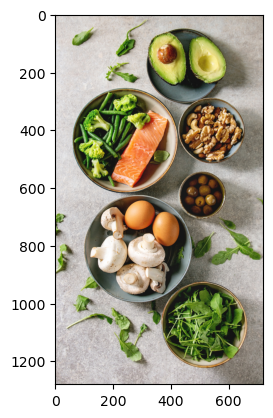

In [55]:
img_c = cv2.imread(os.path.join(data_dir,"healthy","102099575.jpg"))
plt.imshow(cv2.cvtColor(img_c,cv2.COLOR_BGR2RGB))
plt.show()

In [56]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in exts{}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("issue with image{}".format(image_path))

# LOAD DATA

In [57]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 705 files belonging to 2 classes.


In [58]:
data_iterator = data.as_numpy_iterator()

In [59]:
batch = data_iterator.next()

In [60]:
batch[1]

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

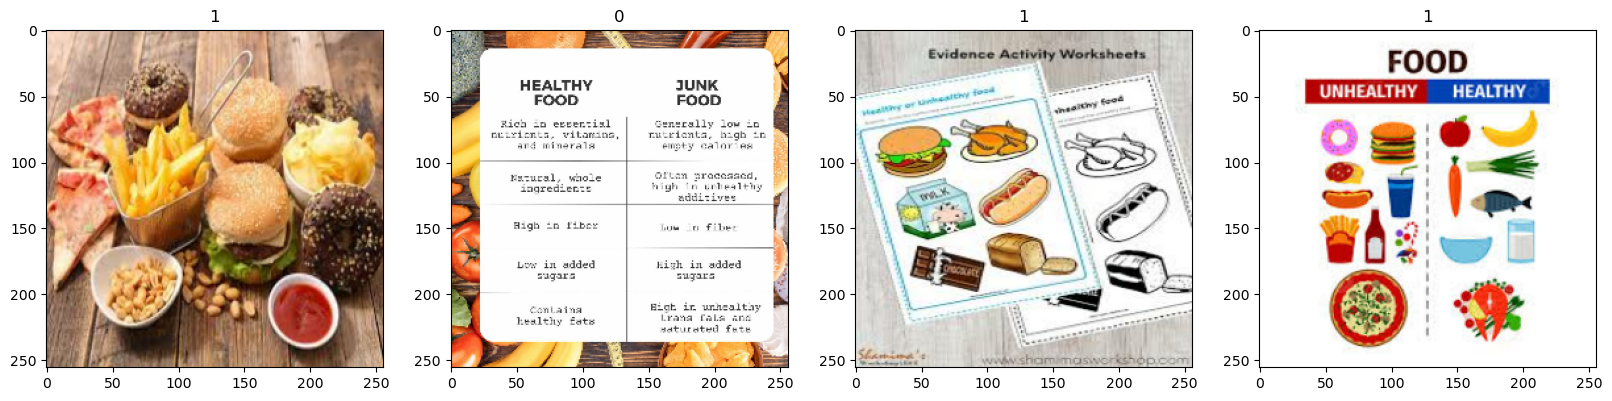

In [61]:
#Healthy = 0
#Unhealthy = 1
fig, ax = plt.subplots(ncols = 4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# PREPROCESS DATA

In [62]:
data = data.map(lambda x,y: (x/255,y))

In [63]:
batch = data.as_numpy_iterator().next()

In [64]:
batch[0].max()

1.0

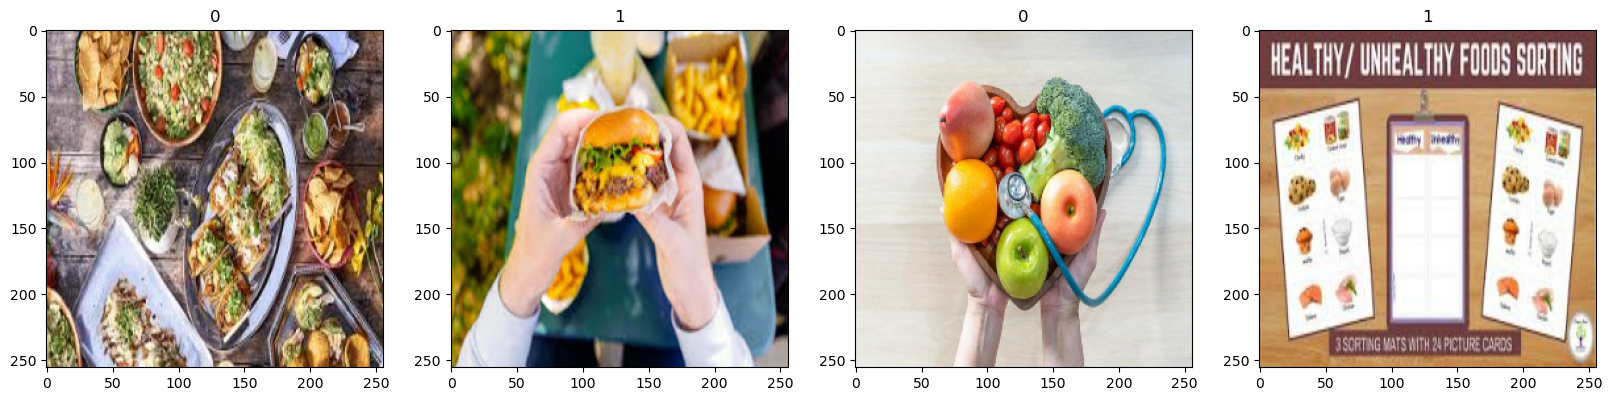

In [65]:
fig, ax = plt.subplots(ncols = 4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [66]:
len(data)

23

In [73]:
train_size = int(len(data)*.7)+1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [75]:
train_size+test_size+val_size

23

In [76]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [78]:
len(test)

2

# Deep Model

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

In [85]:
model = Sequential()

In [86]:
model.add(Conv2D(16, (3,3), 1 , activation = "relu", input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1 , activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1 , activation = "relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation = "relu"))
model.add(Dense(1,activation = "sigmoid"))

In [87]:
model.compile(optimizer="adam",loss = tf.losses.BinaryCrossentropy() , metrics = ["accuracy"])

In [89]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# Train

In [90]:
logdir = "logs"

In [91]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [94]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4780 - loss: 0.9026 - val_accuracy: 0.6562 - val_loss: 0.6586
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 837ms/step - accuracy: 0.6403 - loss: 0.6531 - val_accuracy: 0.7188 - val_loss: 0.5655
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 835ms/step - accuracy: 0.6572 - loss: 0.5981 - val_accuracy: 0.6797 - val_loss: 0.5929
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 871ms/step - accuracy: 0.7453 - loss: 0.5009 - val_accuracy: 0.7734 - val_loss: 0.5017
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 895ms/step - accuracy: 0.8138 - loss: 0.4008 - val_accuracy: 0.8750 - val_loss: 0.3360
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 761ms/step - accuracy: 0.8833 - loss: 0.3177 - val_accuracy: 0.8828 - val_loss: 0.3348
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 683ms/step - accuracy: 0.9251 - loss: 0.2591 - val_accuracy: 0.8359 - val_loss: 0.3439
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 675ms/step - accuracy: 0.9335 - loss: 0.2086 - val_accurac

In [95]:
hist.history

{'accuracy': [0.5165441036224365,
  0.6415441036224365,
  0.6838235259056091,
  0.7738970518112183,
  0.8033088445663452,
  0.8694853186607361,
  0.9154411554336548,
  0.9430146813392639,
  0.9503676295280457,
  0.9742646813392639,
  0.9852941036224365,
  0.966911792755127,
  0.9742646813392639,
  0.9852941036224365,
  0.9779411554336548,
  0.9889705777168274,
  0.9871323704719543,
  0.9852941036224365,
  0.9834558963775635,
  0.9889705777168274],
 'loss': [0.7842947840690613,
  0.641855776309967,
  0.5805981159210205,
  0.4667797088623047,
  0.4128482937812805,
  0.3437194526195526,
  0.26114290952682495,
  0.1955876350402832,
  0.14787906408309937,
  0.10746689140796661,
  0.08788909018039703,
  0.12198920547962189,
  0.08212202787399292,
  0.08151108771562576,
  0.07234256714582443,
  0.05047251656651497,
  0.040775615721940994,
  0.04769732803106308,
  0.041509516537189484,
  0.05427144095301628],
 'val_accuracy': [0.65625,
  0.71875,
  0.6796875,
  0.7734375,
  0.875,
  0.8828125,

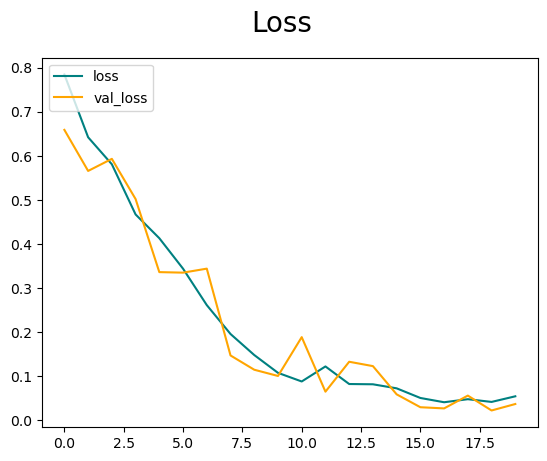

In [96]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

#### val_loss shaky ----- overfitting regularization
#### loss not decreasing ----- bias problem

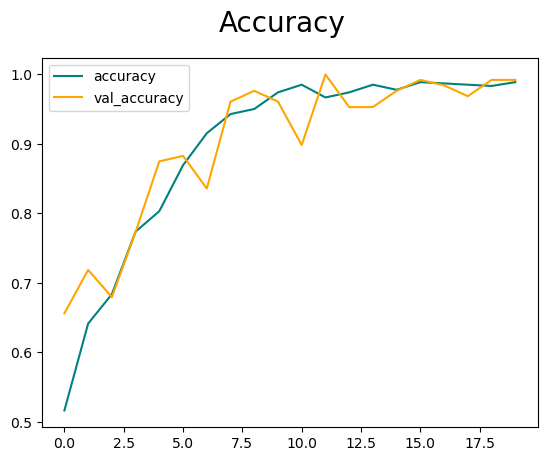

In [97]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="teal", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="orange", label="val_accuracy")
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate Performance

In [98]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [100]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [101]:
len(test)

2

In [102]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


In [103]:
print(f"Precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}")

Precision:1.0,Recall:1.0,Accuracy:1.0


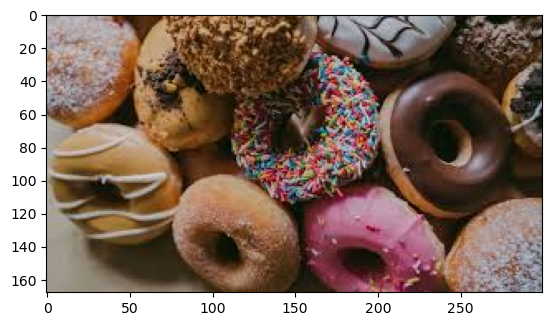

In [122]:
img = cv2.imread("unhealthy_test.jpg")
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

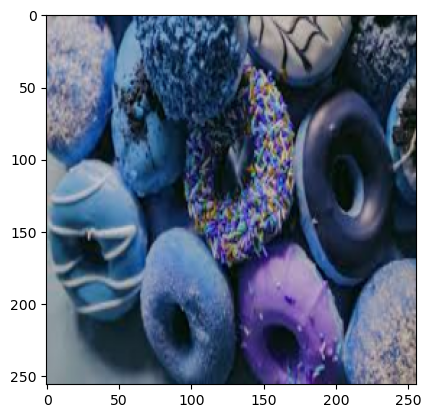

In [123]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [124]:
resize.shape

TensorShape([256, 256, 3])

In [125]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [126]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


In [127]:
yhat

array([[0.9705516]], dtype=float32)

In [128]:
if yhat < 0.5:
    print("food is healthy")
else:
    print("food is unhealthy")

food is unhealthy


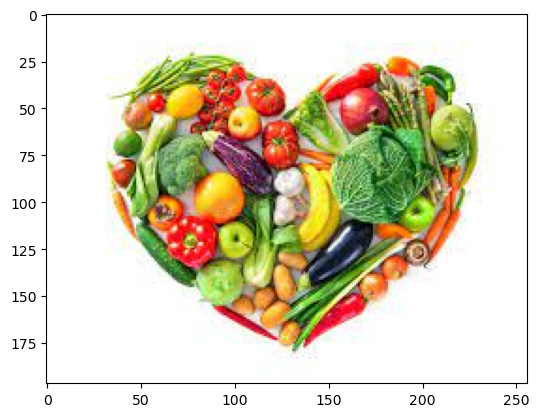

In [130]:
img = cv2.imread("healthy_test.jpg")
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

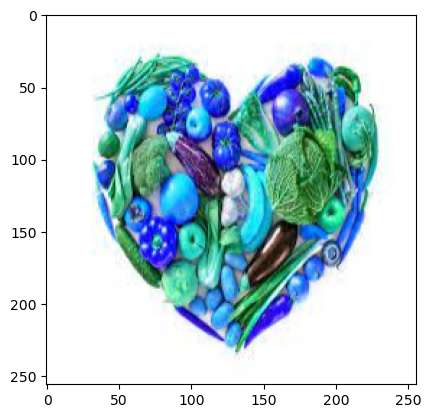

In [131]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [132]:
resize.shape

TensorShape([256, 256, 3])

In [133]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [134]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [135]:
yhat

array([[0.01791708]], dtype=float32)

In [136]:
if yhat < 0.5:
    print("food is healthy")
else:
    print("food is unhealthy")

food is healthy


# Save the Model

In [155]:
from tensorflow.keras.models import load_model
model.save(os.path.join("models","myImageClassifier.keras"))

In [156]:
new_model = load_model(os.path.join("models","myImageClassifier.keras"))

In [158]:
yhat_new = new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [159]:
if yhat_new < 0.5:
    print("food is healthy")
else:
    print("food is unhealthy")

food is healthy
